<a href="https://colab.research.google.com/github/mandarpanse/AI-Healthcare-MSAI/blob/main/mimic_ML_DL-mar31_mortality_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIMIC-III Neural Network: In-Hospital Mortality Prediction

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

## Load and preprocess data

In [2]:
admissions = pd.read_csv("ADMISSIONS.csv")
diagnoses_icd = pd.read_csv("DIAGNOSES_ICD.csv")
d_icd_diagnoses = pd.read_csv("D_ICD_DIAGNOSES.csv")
patients = pd.read_csv("PATIENTS.csv")

patients["dob"] = pd.to_datetime(patients["dob"], errors="coerce")
valid_patients = patients[(patients["dob"].dt.year >= 1900) & (patients["dob"].dt.year <= 2100)]

## Merge data and extract features

In [3]:
primary_diagnoses = diagnoses_icd[diagnoses_icd["seq_num"] == 1]
data = admissions.merge(valid_patients, on="subject_id", how="inner")
data = data.merge(primary_diagnoses[["subject_id", "hadm_id", "icd9_code"]], on=["subject_id", "hadm_id"], how="left")
data = data.merge(d_icd_diagnoses[["icd9_code", "short_title"]], on="icd9_code", how="left")

data["admittime"] = pd.to_datetime(data["admittime"], errors="coerce")
data["age"] = (data["admittime"] - data["dob"]).dt.days // 365
data = data[(data["age"] >= 0) & (data["age"] <= 100)]

## Prepare data for training

In [7]:
features = data[["age", "gender", "ethnicity", "admission_type", "short_title", "hospital_expire_flag"]].dropna()

categorical_cols = ["gender", "ethnicity", "admission_type", "short_title"]
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_cats = encoder.fit_transform(features[categorical_cols])
encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_cols))

X = pd.concat([features[["age"]].reset_index(drop=True), encoded_df], axis=1)
y = features["hospital_expire_flag"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Build and train the neural network

In [8]:
model = Sequential()
model.add(Dense(128, input_dim=X.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, verbose=1)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 0.4487 - loss: 2.4615 - val_accuracy: 0.5714 - val_loss: 0.9220
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6082 - loss: 1.9342 - val_accuracy: 0.5714 - val_loss: 1.6962
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5641 - loss: 2.5035 - val_accuracy: 0.5714 - val_loss: 2.3480
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6082 - loss: 2.6314 - val_accuracy: 0.5714 - val_loss: 2.2073
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5537 - loss: 2.5473 - val_accuracy: 0.5714 - val_loss: 1.7261
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5929 - loss: 1.7103 - val_accuracy: 0.5714 - val_loss: 1.3501
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6755 - loss: 1.3452 - val_accuracy: 0.5714 - val_loss: 1.2332
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.6034 - loss: 2.0087 - val_accuracy: 0.5714 - val_loss: 1.1627
Epoch 9/1

## Evaluate the model

In [9]:
y_pred = (model.predict(X_test) > 0.5).astype("int32").flatten()
print("Classification Report:")
print(classification_report(y_test, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.59      1.00      0.74        10
           1       0.00      0.00      0.00         7

    accuracy                           0.59        17
   macro avg       0.29      0.50      0.37        17
weighted avg       0.35      0.59      0.44        17



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Plot confusion matrix

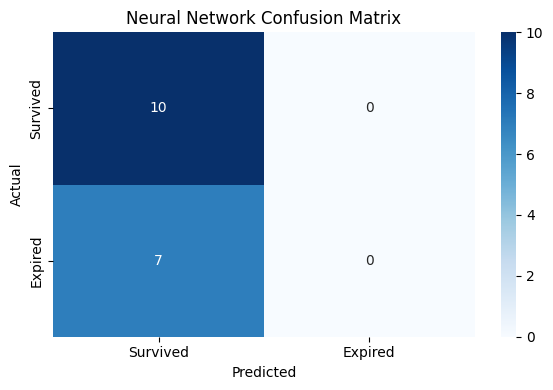

In [10]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Survived", "Expired"], yticklabels=["Survived", "Expired"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Neural Network Confusion Matrix")
plt.tight_layout()
plt.show()